# Group Recommender Systems - Tutorial 2 (Lab 2)


In this tutorial, we will see implement a pipeline for offline evaluation of Group Recommender Systems. After completing this tutorial, you will be able to: 
- Create synthetic groups with different sizes and internal similarities.
- Implement basic strategies for aggregating group members' predicted ratings and provide group recommendations.
- Evaluate the performance of the group recommender systems, using different a coupled or a decoupled evaluation protocol.


![image.png](attachment:eab52f47-77d7-4200-a9b4-56b81a4bf722.png)

#### Summary [TO UPDATE]

1. Dataset
2. Preprocessing
3. Synthetic Groups Generation
4. Train/Test split
5. Individual RS training and generating predicted ratings
6. Aggregation strategies: generating group recommendations
7. Evaluation
    1. Coupled Evaluation
    2. Decoupled Evaluation

#### 1. Dataset


We will use the preprocessed dataset provided in the first lab, under the folder *preprocessed_dataset*. The dataset has been obtained from the 
[Movielens latest small](https://www.kaggle.com/grouplens/movielens-latest-small) dataset (providing user's ratings) and the [Wikipedia Movie Plots](https://www.kaggle.com/jrobischon/wikipedia-movie-plots) dataset (providing movies' information). Check the notebook **Dataset Preprocessing** in the Lab 1 for details on how the datasets have been preprocessed and merged.

The dataset contains two CSV files, following  the structure of the Movielens dataset:
1. ratings.csv: contains the information about the feedback of the users for the movies. Each row contains the id of a user,the id of a movie, and the rating that the user gave to the movie. It also contains the timestamp, but we will not use it in this tutorial.
2. movies.csv: contains the information about the movies.


We start using the [pandas](https://pandas.pydata.org/) library to read the content of the CSV files and use it, as we did in the Lab 1.


In [203]:
import pandas as pd


In [204]:
ratings_df = pd.read_csv("XWines_Full_21M_ratings.csv") 
display(ratings_df.head(10))

RatingID   UserID  WineID Vintage  Rating                 Date
0         1  1604441  136103    1950     4.0  2019-10-14 11:20:52
1         2  1291483  136103    1950     5.0  2019-11-28 03:36:33
2         3  1070605  104036    1950     5.0  2017-12-28 10:15:55
3         4  1080181  144864    1950     5.0  2016-06-23 02:16:22
4         5  1834379  111430    1950     5.0  2021-05-16 17:58:14
5         6  1995440  157985    1950     4.0  2016-01-06 22:14:14
6         7  1166181  101794    1950     5.0  2018-04-15 12:04:46
7         8  1839846  136103    1950     5.0  2020-07-18 15:41:19
8         9  1693747  136103    1950     1.0  2018-11-23 01:48:57
9        10  1478537  135897    1950     4.0  2015-05-04 19:52:09

In [205]:
ratings_df = ratings_df.drop(columns=['Vintage', 'Date'])
display(ratings_df.head(10))

RatingID   UserID  WineID  Rating
0         1  1604441  136103     4.0
1         2  1291483  136103     5.0
2         3  1070605  104036     5.0
3         4  1080181  144864     5.0
4         5  1834379  111430     5.0
5         6  1995440  157985     4.0
6         7  1166181  101794     5.0
7         8  1839846  136103     5.0
8         9  1693747  136103     1.0
9        10  1478537  135897     4.0

In [206]:
wine_df = pd.read_csv('XWines_Full_100K_wines.csv', index_col="WineID")
display(wine_df.head(5))
print(wine_df.columns)

WineName       Type  \
WineID                                               
100001               Espumante Moscatel  Sparkling   
100002                       Ancellotta        Red   
100003               Cabernet Sauvignon        Red   
100004                   Virtus Moscato      White   
100005  Maison de Ville Cabernet-Merlot        Red   

                            Elaborate                            Grapes  \
WineID                                                                    
100001                  Varietal/100%                ['Muscat/Moscato']   
100002                  Varietal/100%                    ['Ancellotta']   
100003                  Varietal/100%            ['Cabernet Sauvignon']   
100004                  Varietal/100%                ['Muscat/Moscato']   
100005  Assemblage/Bordeaux Red Blend  ['Cabernet Sauvignon', 'Merlot']   

                                                Harmonize   ABV  \
WineID                                                            
100001                 ['Pork', 'Rich Fish', 'Shellfish']   7.5   
100002  ['Beef', 'Barbecue', 'Codfish', 'Pasta', 'Pizz...  12.0   
100003                        ['Beef', 'Lamb', 'Poultry']  12.0   
100004                                  ['Sweet Dessert']  12.0   
100005           ['Beef', 'Lamb', 'Game Meat', 'Poultry']  11.0   

                 Body Acidity Code Country  RegionID    RegionName  WineryID  \
WineID                                                                         
100001  Medium-bodied    High   BR  Brazil      1001  Serra Gaúcha     10001   
100002  Medium-bodied  Medium   BR  Brazil      1001  Serra Gaúcha     10001   
100003    Full-bodied    High   BR  Brazil      1001  Serra Gaúcha     10002   
100004  Medium-bodied  Medium   BR  Brazil      1001  Serra Gaúcha     10003   
100005    Full-bodied  Medium   BR  Brazil      1001  Serra Gaúcha     10000   

            WineryName                                 Website  \
WineID                                                           
100001     Casa Perini        http://www.vinicolaperini.com.br   
100002     Casa Perini        http://www.vinicolaperini.com.br   
100003    Castellamare  https://www.emporiocastellamare.com.br   
100004  Monte Paschoal         http://www.montepaschoal.com.br   
100005          Aurora        http://www.vinicolaaurora.com.br   

                                                 Vintages  
WineID                                                     
100001  [2020, 2019, 2018, 2017, 2016, 2015, 2014, 201...  
100002  [2016, 2015, 2014, 2013, 2012, 2011, 2010, 200...  
100003  [2021, 2020, 2019, 2018, 2017, 2016, 2015, 201...  
100004  [2021, 2020, 2019, 2018, 2017, 2016, 2015, 201...  
100005  [2021, 2020, 2019, 2018, 2017, 2016, 2015, 201...

Index(['WineName', 'Type', 'Elaborate', 'Grapes', 'Harmonize', 'ABV', 'Body',
       'Acidity', 'Code', 'Country', 'RegionID', 'RegionName', 'WineryID',
       'WineryName', 'Website', 'Vintages'],
      dtype='object')


#### 2. Preprocessing


To generate synthetic groups we need to be able to evaluate similarities between users. As we only have the information about Ratings, we will use this. Hence, we want to focus on users for which we can compute this similarity, requiring a minimum amount of rated WineIDs (and discarding the remaining users). At the same time, we want to focus on WineIDs rated by a certain number of users. In this pre-processing step, we will filter out users and WineIDs not having enough ratings. 

In [207]:
# Check number of ratings per WineID
rating_per_WineID_df = ratings_df.groupby(['WineID']).count().sort_values(by="Rating", ascending=False)
display(rating_per_WineID_df)

# Check number of ratings per user
rating_per_user_df = ratings_df.groupby(['UserID']).count().sort_values(by="Rating", ascending=False)
display(rating_per_user_df)

RatingID  UserID  Rating
WineID                          
155289     27415   27415   27415
179010     23626   23626   23626
179011     21216   21216   21216
111391     20913   20913   20913
167418     20817   20817   20817
...          ...     ...     ...
200628         5       5       5
200629         5       5       5
200630         5       5       5
200631         5       5       5
200757         5       5       5

[100646 rows x 3 columns]

RatingID  WineID  Rating
UserID                           
1084433      2986    2986    2986
1034989      2979    2979    2979
1070878      2613    2613    2613
1048267      2597    2597    2597
1160536      2392    2392    2392
...           ...     ...     ...
1709634         5       5       5
1709635         5       5       5
1709639         5       5       5
1709708         5       5       5
1709718         5       5       5

[1056079 rows x 3 columns]

In [208]:
# min_ratings_per_WineID = 1000
# min_ratings_per_user = 200

min_ratings_per_WineID = 10
min_ratings_per_user = 10



In [209]:
#  randomly select the users and wineID
# Ensure there are enough unique WineIDs and UserIDs
# wine_df.reset_index(inplace=True)
wine_count = ratings_df['WineID'].nunique()
# user_count = selected_ratings_df['UserID'].nunique()

# Check if there are at least 40,000 wines and 8,000 users
if wine_count >= 1000 :
    # Randomly sample 40,000 wines
    selected_wine_ids = ratings_df['WineID'].drop_duplicates().sample(n=1000)
    
    # Filter the DataFrame to only include those wines
    ratings_df = ratings_df[ratings_df['WineID'].isin(selected_wine_ids)]    
    # Now we should have the desired matrix
    display(ratings_df.shape)
    display(ratings_df.head())
else:
    print(f"Not enough data: {wine_count} wines")


(237940, 4)

RatingID   UserID  WineID  Rating
411       412  1761188  119225     5.0
444       445  1556410  111417     5.0
494       495  1213917  119225     3.0
500       501  1111904  112360     4.5
686       687  1182445  119225     5.0

In [210]:
rating_per_item_df = ratings_df.groupby(['WineID']).count().sort_values(by="Rating", ascending=False)
print("Dataframe of rating by wineID   (should have 1000 Wine)")
display(rating_per_item_df)

# Check number of ratings per user
rating_per_user_df = ratings_df.groupby(['UserID']).count().sort_values(by="Rating", ascending=False)
print("Check how many ratings for per user")
display(rating_per_user_df)


# select items with the desidered number of ratings

selected_items = list(rating_per_item_df.loc[rating_per_item_df['Rating'] >= min_ratings_per_WineID].reset_index()['WineID'])
display(ratings_df.shape)
selected_ratings_df = ratings_df.loc[ratings_df['WineID'].isin(selected_items)]
display(selected_ratings_df.shape)

# Check number of ratings per item
rating_per_item_df = selected_ratings_df.groupby(['WineID']).count().sort_values(by="Rating", ascending=False)
print("check number of ratings for per item ")
display(rating_per_item_df)
# Check number of ratings per wine 
rating_per_user_df = selected_ratings_df.groupby(['UserID']).count().sort_values(by="Rating", ascending=False)
print("check number of rating per user ")
display(rating_per_user_df)


# select users with the desidered number of ratings
selected_users = list(rating_per_user_df.loc[rating_per_user_df['Rating'] >= min_ratings_per_user].reset_index()['UserID'])
print(" users with the desidered number of ratings")
display(selected_ratings_df.shape)
selected_ratings_df = selected_ratings_df.loc[ratings_df['UserID'].isin(selected_users)]
display(selected_ratings_df.shape)

# Check number of ratings per item
rating_per_item_df = selected_ratings_df.groupby(['WineID']).count().sort_values(by="Rating", ascending=False)
print(" number of ratings per item")
display(rating_per_item_df)

# Check number of ratings per user
rating_per_user_df = selected_ratings_df.groupby(['UserID']).count().sort_values(by="Rating", ascending=False)
print(" number of ratings per user")
display(rating_per_user_df)

Dataframe of rating by wineID   (should have 1000 Wine)


RatingID  UserID  Rating
WineID                          
167420     17759   17759   17759
179018      9864    9864    9864
179038      6781    6781    6781
111417      5168    5168    5168
135871      4578    4578    4578
...          ...     ...     ...
178950         5       5       5
178989         5       5       5
162231         5       5       5
162245         5       5       5
162264         5       5       5

[1000 rows x 3 columns]

Check how many ratings for per user


RatingID  WineID  Rating
UserID                           
1006657        32      32      32
1034989        30      30      30
1084433        29      29      29
1160536        28      28      28
1165081        28      28      28
...           ...     ...     ...
1000044         1       1       1
1000046         1       1       1
1000051         1       1       1
1000055         1       1       1
1000057         1       1       1

[177528 rows x 3 columns]

(237940, 4)

(237102, 4)

check number of ratings for per item 


RatingID  UserID  Rating
WineID                          
167420     17759   17759   17759
179018      9864    9864    9864
179038      6781    6781    6781
111417      5168    5168    5168
135871      4578    4578    4578
...          ...     ...     ...
153094        10      10      10
110433        10      10      10
110453        10      10      10
189937        10      10      10
189903        10      10      10

[874 rows x 3 columns]

check number of rating per user 


RatingID  WineID  Rating
UserID                           
1006657        32      32      32
1034989        30      30      30
1084433        29      29      29
1165081        28      28      28
1160536        28      28      28
...           ...     ...     ...
1000012         1       1       1
1000011         1       1       1
1000067         1       1       1
1000005         1       1       1
2063385         1       1       1

[177035 rows x 3 columns]

 users with the desidered number of ratings


(237102, 4)

(5253, 4)

 number of ratings per item


RatingID  UserID  Rating
WineID                          
111435       182     182     182
111417       121     121     121
167420        90      90      90
135871        87      87      87
155404        84      84      84
...          ...     ...     ...
187120         1       1       1
187170         1       1       1
170354         1       1       1
170546         1       1       1
171378         1       1       1

[669 rows x 3 columns]

 number of ratings per user


RatingID  WineID  Rating
UserID                           
1006657        32      32      32
1034989        30      30      30
1084433        29      29      29
1160536        28      28      28
1165081        28      28      28
...           ...     ...     ...
1269082        10      10      10
1269284        10      10      10
1216873        10      10      10
1219709        10      10      10
1220945        10      10      10

[397 rows x 3 columns]

#### 3. Synthetic groups generation



![image.png](attachment:e4abdc86-40b8-4ae4-957b-b3ad5366207c.png)


- Which types of groups will we generate? 
- Which sizes we want to evaluate?
- Similarity metric?
- How many groups?

We need to generate groups using the users from the dataset. As we don't have any information for this, we can only use the provided ratings. Two reasonable criteria to use in this case are:
1. Size: we can generate groups of different sizes and compare the performances of our strategies for different group sizes.
2. Similarity: we can generate easier and more difficult groups considering the internal similarity of the preferences.


#### 3.1 Similarity metric

In this example, we use the pearson correlation. This is often used in these types of evaluations. We assume two users are similar if their "rating patterns" are similar. This may not have sense in all cases, and the choice of the similarity metric needs to be motivated for the specific dataset.

In [211]:
# computing pearson similarity between each pair of users

import numpy as np

ratings_df = selected_ratings_df

user_matrix = ratings_df.pivot_table(columns='WineID', index='UserID', values='Rating')

user_id_set = set(ratings_df['UserID'])
user_id_indexes = user_matrix.index.values
display(type(user_id_indexes))
user_matrix = user_matrix.fillna(0)
numpy_array = user_matrix.to_numpy()
sim_matrix = np.corrcoef(numpy_array)

display(user_matrix)
display(sim_matrix)

numpy.ndarray

WineID   100079  100089  100391  100416  100465  100954  101028  101236  \
UserID                                                                    
1000004     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1000049     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1000065     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1000069     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1000085     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
...         ...     ...     ...     ...     ...     ...     ...     ...   
1579761     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1674055     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1726164     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1878271     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1978784     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

WineID   101687  101719  ...  197827  197840  197960  198039  198102  198199  \
UserID                   ...                                                   
1000004     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
1000049     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
1000065     4.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
1000069     3.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
1000085     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
...         ...     ...  ...     ...     ...     ...     ...     ...     ...   
1579761     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
1674055     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
1726164     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
1878271     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
1978784     3.5     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   

WineID   198283  198569  198802  198999  
UserID                                   
1000004     0.0     0.0     0.0     0.0  
1000049     0.0     0.0     0.0     0.0  
1000065     0.0     0.0     0.0     0.0  
1000069     0.0     0.0     0.0     0.0  
1000085     0.0     0.0     0.0     0.0  
...         ...     ...     ...     ...  
1579761     0.0     0.0     0.0     0.0  
1674055     0.0     0.0     0.0     0.0  
1726164     0.0     0.0     0.0     0.0  
1878271     0.0     0.0     0.0     0.0  
1978784     0.0     0.0     0.0     0.0  

[397 rows x 669 columns]

array([[ 1.        ,  0.10638788, -0.02149607, ..., -0.0155411 ,
        -0.02187792, -0.01798115],
       [ 0.10638788,  1.        ,  0.05593288, ...,  0.10347167,
         0.0689155 ,  0.17536932],
       [-0.02149607,  0.05593288,  1.        , ..., -0.01875954,
         0.09683791,  0.19201213],
       ...,
       [-0.0155411 ,  0.10347167, -0.01875954, ...,  1.        ,
        -0.01909278,  0.09460457],
       [-0.02187792,  0.0689155 ,  0.09683791, ..., -0.01909278,
         1.        ,  0.04173356],
       [-0.01798115,  0.17536932,  0.19201213, ...,  0.09460457,
         0.04173356,  1.        ]])

Text(0.5, 0, "Pearson's Correlation Coeficient")

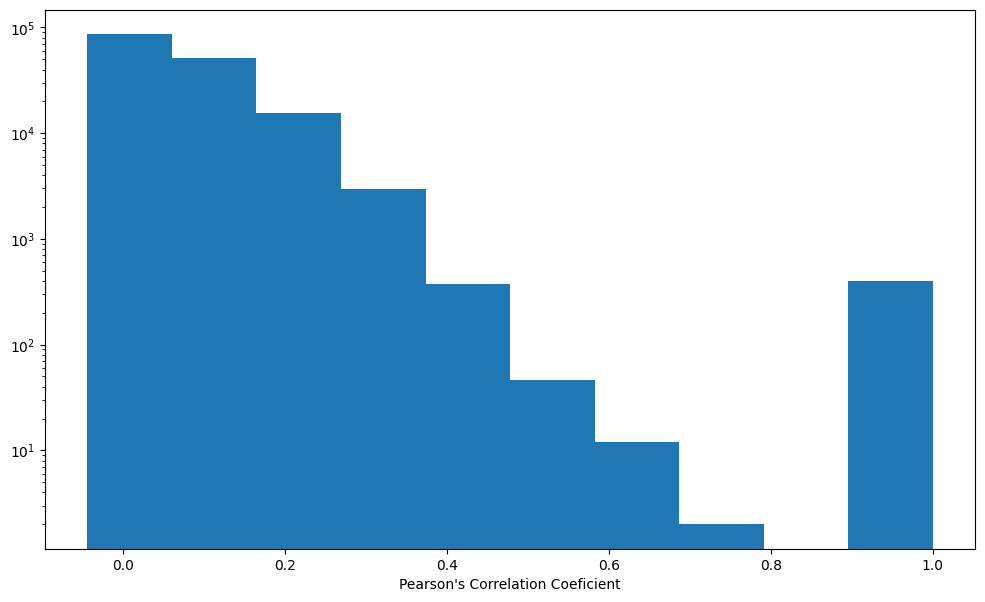

In [212]:
# visualizing similarity distributions

%matplotlib inline
import matplotlib.pyplot as plt

plt.hist(sim_matrix.flatten())
plt.yscale("log")
plt.xlabel("Pearson's Correlation Coeficient")

#### 3.2 Group Generation

We focus here on types of groups defined on the basis of the internal similarity between the group member's preferences. The code below generates:
- types: similar, random, divergent
- sizes: 2 to 8 members per group
- number of group: 20 for each type and size combination

In [213]:
from importlib import reload

import groups_generators as groups_gen_utils
reload(groups_gen_utils)
import groups_generators as groups_gen_utils

# group_sizes_to_create = [2,4,8] 
group_sizes_to_create = [ 3, 4, 5, 6, 7, 8]
group_similarity_to_create = [groups_gen_utils.GroupsGenerator.RANDOM,groups_gen_utils.GroupsGenerator.SIMILAR]
group_number = 20

group_list = list()
for group_to_create in group_similarity_to_create:
    grpGenerator = groups_gen_utils.GroupsGenerator.getGroupsGenerator(group_to_create)
    current_group_list = grpGenerator.generateGroups(user_id_indexes, user_id_set, sim_matrix, group_sizes_to_create, group_number)
    group_list = group_list + current_group_list

groups_df = pd.DataFrame.from_records(group_list)
group_dict = dict()
for group_id, group in zip(range(len(group_list)), group_list):
    group_dict[group_id] = group

# display(group_list)
    
display(groups_df)

20
40
60
80
100
120
20
40
60
80
100
120


group_size group_similarity  \
0             3           random   
1             3           random   
2             3           random   
3             3           random   
4             3           random   
..          ...              ...   
235           8          similar   
236           8          similar   
237           8          similar   
238           8          similar   
239           8          similar   

                                         group_members  avg_similarity  
0                          [1164660, 1166998, 1185372]        0.075960  
1                          [1153092, 1137772, 1121579]        0.012210  
2                          [1126323, 1049201, 1726164]        0.084387  
3                          [1196586, 1110161, 1213347]        0.067667  
4                          [1223825, 1218108, 1389959]        0.037443  
..                                                 ...             ...  
235  [1163440, 1007186, 1216053, 1003635, 1276014, ...        0.211667  
236  [1195528, 1152108, 1034765, 1234749, 1194826, ...        0.257864  
237  [1218093, 1184816, 1165947, 1166998, 1204999, ...        0.165145  
238  [1051351, 1152108, 1173759, 1035878, 1102675, ...        0.169271  
239  [1166998, 1002291, 1230090, 1269082, 1147909, ...        0.180359  

[240 rows x 4 columns]

It is useful to verify the groups we created. In the code below we compare the avereage internal similarity for all the types of groups we created

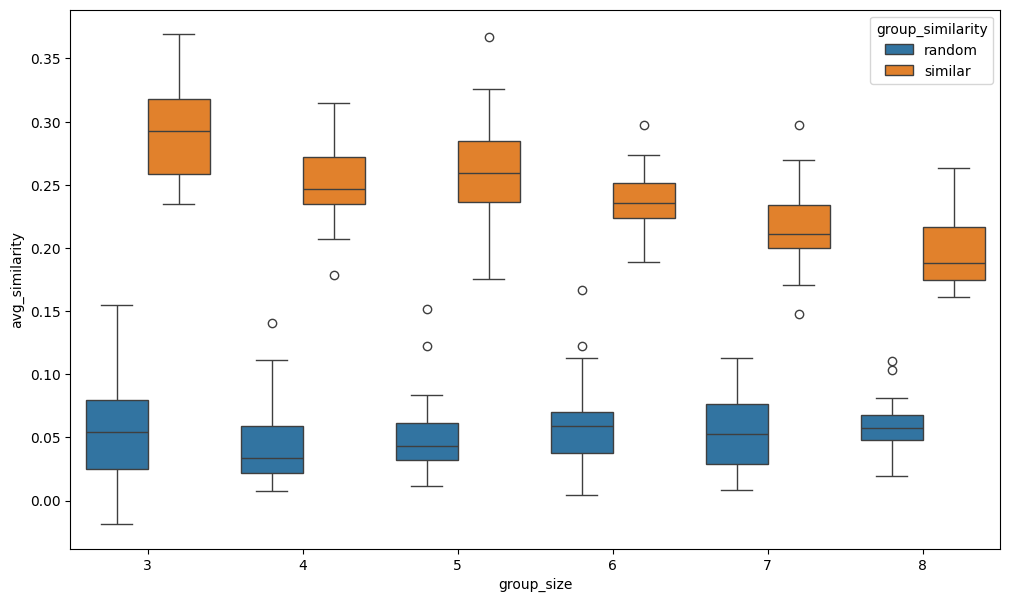

In [214]:
# Visualizing similarities for each type of group we created

import seaborn as sns


plt.rcParams["figure.figsize"] = (12,7)
sns.boxplot(x = groups_df['group_size'],
            y = groups_df['avg_similarity'],
            hue = groups_df['group_similarity'])
import matplotlib.pyplot as plt

#### 4. Train/Test split


![image.png](attachment:6212212a-67b5-4e2b-b312-654884627ba2.png)

- Which strategy?
- Stratified split?
  
The choice of the criteria for splitting should be carefully defined on the basis of the problem we have, as well as the computational constraints. In this example, due to time constraints, we use a Hold-out (80-20 split) stratified by user. This ensures to have 80% of evaluations in the training set and 20% in the test set for each user. Different methodologies could be applied, and this choice needs to be properly motivated.

In [215]:
ratings_df =ratings_df.rename(columns={
    'RatingID': 'ratingId',  # Fixed typo
    'UserID': 'user',
    'WineID': 'item',
    'Vintage': 'vintage',
    'Rating': 'rating',
    'Date': 'date'
})

In [216]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support

display(ratings_df.shape)
WineIDs = set(ratings_df["item"].tolist())
users = set(ratings_df["user"].tolist())

display(len(WineIDs))
display(len(users))

train_df, test_df = train_test_split(ratings_df, test_size=0.2, stratify=ratings_df[["user"]])

display(train_df.shape)
display(train_df.head(5))
display(test_df.shape)
display(test_df.head(5))

(5253, 4)

669

397

(4202, 4)

ratingId     user    item  rating
6241194    6241195  1168418  180428     4.0
1009167    1009168  1054846  111435     4.5
12200415  12200416  1176689  193363     3.0
7162654    7162655  1106820  135871     4.5
16002486  16002487  1005854  114370     4.0

(1051, 4)

ratingId     user    item  rating
6209568    6209569  1129430  180637     5.0
12103625  12103626  1235289  155757     3.5
5533277    5533278  1000180  179120     4.5
1858195    1858196  1210668  111417     4.0
8522440    8522441  1084567  136405     3.5

In [217]:
display(ratings_df.head)

<bound method NDFrame.head of           ratingId     user    item  rating
3085          3086  1199660  112360     5.0
4649          4650  1124584  111417     5.0
4747          4748  1215320  111435     5.0
5595          5596  1055875  111417     5.0
12244        12245  1217650  111417     1.5
...            ...      ...     ...     ...
21001856  21001857  1088861  147462     4.0
21009197  21009198  1220952  120259     4.0
21011105  21011106  1084567  112473     4.0
21012854  21012855  1139706  137878     4.0
21013400  21013401  1005800  112985     5.0

[5253 rows x 4 columns]>

#### 5. Individual RS training and generating predicted ratings.

![image.png](attachment:32ac7e2e-3ef4-4dd9-98c8-3766e972116f.png)

- Which strategy to use?
- Which WineIDs we consider for computing the predicted ratings?


In [218]:
train_df = train_df.rename(columns={
    'RatingID': 'ratingId',  # Fixed type
    'UserID': 'user',
    'WineID': 'item',
    'Vintage': 'vintage',
    'Rating': 'rating',
    'Date': 'date'
})


In [219]:
#Individual RS

from lenskit.algorithms import Recommender
from lenskit.algorithms.user_knn import UserUser

user_user = UserUser(15,min_nbrs=3)  # Minimum (3) and maximum (15) number of neighbors to consider
recsys = Recommender.adapt(user_user)
recsys.fit(train_df)
print(recsys)

TopN/UserUser(nnbrs=15, min_sim=0)


In [220]:
filtered_df = extended_test_df[(extended_test_df['user'] == 1572876)]
print(filtered_df)
#print(recsys.predict(filtered_df))

             item     user    rating
2          131072  1572876       NaN
24070      196611  1572876  3.488636
48138      196612  1572876  3.500000
72206      163849  1572876  3.305690
96274      196618  1572876       NaN
...           ...      ...       ...
189703978  163822  1572876  3.250808
189728046  131060  1572876       NaN
189752114  163829  1572876  3.846218
189776182  196600  1572876       NaN
189800250  196602  1572876  3.506623

[7887 rows x 3 columns]


In [221]:
# Generate predicted ratings

# test_df['predicted_rating'] = recsys.predict(test_df)
test_WineID = set(test_df["item"].tolist())
test_user = set(test_df["user"].tolist())
test_rating=set(test_df["rating"].tolist())

display(len(test_WineID))
display(test_WineID)
display(len(test_user))
display(test_user)
display(len(test_rating))
display(test_rating)

392

{100079,
 100391,
 100416,
 100465,
 101028,
 101687,
 101719,
 101860,
 102148,
 102182,
 102288,
 102348,
 102349,
 102420,
 102803,
 103084,
 103427,
 103527,
 103918,
 104051,
 104122,
 104147,
 104171,
 104486,
 104575,
 104614,
 104642,
 105283,
 105463,
 105464,
 105723,
 106034,
 106105,
 106616,
 106753,
 106910,
 106911,
 107066,
 107307,
 107314,
 107362,
 107659,
 107690,
 107759,
 107878,
 107888,
 107952,
 107964,
 108184,
 108552,
 108658,
 108766,
 108891,
 108916,
 109015,
 109680,
 109952,
 111417,
 111435,
 111527,
 111539,
 111604,
 111650,
 111885,
 111915,
 112023,
 112046,
 112127,
 112139,
 112227,
 112352,
 112360,
 112473,
 112498,
 112503,
 112524,
 112557,
 112605,
 112607,
 112674,
 112694,
 112705,
 112710,
 112836,
 112961,
 112985,
 113156,
 113214,
 113343,
 113701,
 113997,
 114001,
 114007,
 114259,
 114278,
 114279,
 114370,
 114629,
 114821,
 114903,
 115368,
 115660,
 115883,
 116077,
 116097,
 116268,
 116344,
 116528,
 116771,
 116776,
 116782,
 

397

{1000004,
 1000049,
 1000065,
 1000069,
 1000085,
 1000180,
 1000272,
 1000365,
 1000413,
 1000494,
 1000559,
 1001871,
 1001907,
 1001909,
 1001937,
 1002016,
 1002043,
 1002252,
 1002291,
 1003603,
 1003635,
 1003660,
 1003734,
 1003868,
 1004015,
 1004834,
 1004885,
 1004940,
 1005078,
 1005311,
 1005724,
 1005750,
 1005800,
 1005828,
 1005854,
 1006022,
 1006062,
 1006131,
 1006416,
 1006433,
 1006657,
 1006889,
 1007186,
 1007187,
 1007716,
 1008458,
 1008661,
 1009556,
 1009797,
 1009917,
 1010245,
 1010673,
 1011504,
 1016381,
 1019005,
 1019334,
 1019610,
 1020040,
 1021151,
 1021298,
 1028358,
 1029534,
 1034367,
 1034725,
 1034753,
 1034765,
 1034809,
 1034989,
 1035125,
 1035319,
 1035391,
 1035878,
 1038350,
 1048267,
 1048395,
 1048656,
 1048983,
 1049201,
 1051351,
 1052906,
 1054749,
 1054846,
 1054914,
 1054915,
 1055113,
 1055133,
 1055317,
 1055520,
 1055875,
 1057244,
 1059058,
 1060068,
 1064787,
 1065595,
 1070605,
 1070878,
 1070932,
 1072067,
 1072205,
 1075311,


9

{1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0}

In [222]:
extended_test_df = pd.DataFrame({'item': list(test_WineID)}).merge(pd.DataFrame({'user': list(test_user)}), how='cross')


display(extended_test_df)

item     user
0       194566  1038350
1       194566  1077266
2       194566  1212442
3       194566  1054749
4       194566  1134628
...        ...      ...
155619  194558  1177579
155620  194558  1189869
155621  194558  1396724
155622  194558  1206263
155623  194558  1193982

[155624 rows x 2 columns]

In [225]:
extended_test_df['rating'] = recsys.predict(extended_test_df)

display(extended_test_df)
# Count the number of NaN (null) values in the 'rating' column
null_ratings_count = extended_test_df['rating'].isnull().sum()

# Display the result
print(f'Number of null ratings: {null_ratings_count}')

# number_of_Nan=extended_test_df.groupby(['rating']).count()
# display(number_of_Nan)




item     user    rating
0       194566  1038350       NaN
1       194566  1077266       NaN
2       194566  1212442       NaN
3       194566  1054749       NaN
4       194566  1134628       NaN
...        ...      ...       ...
155619  194558  1177579  3.747821
155620  194558  1189869       NaN
155621  194558  1396724       NaN
155622  194558  1206263  3.446537
155623  194558  1193982  3.077453

[155624 rows x 3 columns]

Number of null ratings: 108851


#### 6. Aggregation strategies: generating group recommendations

![image.png](attachment:2990ef48-a9aa-4dce-a4b9-ab3f47168f03.png)


- Which strategies we want to evaluate?

In [184]:
import aggregators as aggr_utils
reload(aggr_utils)
import aggregators as aggr_utils

aggregation_strategies = ["BASE"]
recommendations_number = 10

def generate_group_recommendations_forall_groups(test_df, group_dict, recommendations_number):
    group_recommendations = dict()
    for group_id in group_dict:
        
#         print(datetime.now(), group_id)
        
        # extract group info
        group = group_dict[group_id]
        group_size = group['group_size']
        group_similarity = group['group_similarity']
        group_members = group['group_members']
            
        group_ratings = test_df.loc[test_df['user'].isin(group_members)]
        
        group_rec = dict()
        for aggregation_strategy in aggregation_strategies:
            agg = aggr_utils.AggregationStrategy.getAggregator(aggregation_strategy)
            group_rec = {**group_rec, **agg.generate_group_recommendations_for_group(group_ratings, recommendations_number)}
        
        
        group_recommendations[group_id] = group_rec
        
    return group_recommendations

In [185]:
group_recommendations = generate_group_recommendations_forall_groups(extended_test_df, group_dict, recommendations_number)

display(group_recommendations)

KeyboardInterrupt: 

In [150]:
# Visualize the group recommendation

group_recommender_full_dataframe=group_recommendations
wine_df.reset_index(inplace=True)

wine_df= pd.DataFrame(wine_df)
recommendations_df = pd.DataFrame([
    {'strategy': strategy, 'wine_id': wine_id}
    for strategy, wine_ids in group_recommendations.items()
    for wine_id in wine_ids
])
recommendations_list = []
for group_id, strategies in group_recommendations.items():
    for strategy, wine_ids in strategies.items():
        for wine_id in wine_ids:
            recommendations_list.append({'group_id': group_id, 'strategy': strategy, 'wine_id': wine_id})

recommendations_df = pd.DataFrame(recommendations_list)

print(wine_df.columns)
recommendations_df['wine_id'] = recommendations_df['wine_id'].astype(str)
wine_df['WineID'] = wine_df['WineID'].astype(str) 
merged_df = recommendations_df.merge(wine_df, left_on='wine_id', right_on='WineID', how='left')
print("Merged DataFrame:")
print(merged_df)

for group_id in merged_df['group_id'].unique():
    group_df = merged_df[merged_df['group_id'] == group_id]
    print(f"DataFrame for group '{group_id}':")
    print(group_df)
    print("\n")



Index(['WineID', 'WineName', 'Type', 'Elaborate', 'Grapes', 'Harmonize', 'ABV',
       'Body', 'Acidity', 'Code', 'Country', 'RegionID', 'RegionName',
       'WineryID', 'WineryName', 'Website', 'Vintages'],
      dtype='object')
Merged DataFrame:
      group_id strategy wine_id  WineID  \
0            0      ADD  175817  175817   
1            0      ADD  115885  115885   
2            0      ADD  111983  111983   
3            0      ADD  107151  107151   
4            0      ADD  103471  103471   
...        ...      ...     ...     ...   
9595       239      MPL  137148  137148   
9596       239      MPL  114680  114680   
9597       239      MPL  123571  123571   
9598       239      MPL  102207  102207   
9599       239      MPL  112837  112837   

                                    WineName          Type  \
0                   Semillon-Sauvignon Blanc         White   
1     Riesling Alsace Grand Cru 'Sommerberg'         White   
2                   Brut Champagne (Vintage)     

#### 7. Evaluation

![image.png](attachment:4155f746-af5b-43a0-8e72-746dd761ca34.png)

- Coupled or Decoupled?
- Metric? How we aggregate metrics for group members?

#### 7.1 NDCG metric

- We see an implementation of the NDCG metric.


In [151]:
def evaluateUserNDCG(user_ground_truth, group_recommendation):
    dcg = 0

    for k, item in enumerate(group_recommendation):
        dcg = dcg + ((user_ground_truth.loc[item, "final_rating"] if item in user_ground_truth.index else 0) / np.log2(k + 2)) # +2? CHeck with the course slides

    idcg = 0
    user_ground_truth.sort_values("final_rating", inplace=True, ascending=False)
    for k in range(min(len(user_ground_truth), len(group_recommendation))):
        idcg = idcg + (user_ground_truth.iloc[k]["final_rating"] / np.log2(k + 2)) # +2? CHeck with the course slides
    if idcg > 0:
        ndcg = dcg / idcg
    else:
        ndcg = 0

    return ndcg


#### 7.2 Aggregating metric for group members

- We report results aggregating using: mean, min, minmax.

In [152]:
def evaluateGroupRecommendation(group_ground_truth, group_recommendation, group_members):
    ndcg_list = list()
    dcg_list = list()
    binarize_feedback=False
    binarize_feedback_positive_threshold=10
    for user in group_members:
        
        user_ground_truth = group_ground_truth.loc[group_ground_truth['user'] == user]
        user_ground_truth.set_index("item", inplace=True)

        # feedback binarization
        if binarize_feedback == True:
            user_ground_truth["final_rating"] = 0
            user_ground_truth.loc[user_ground_truth.rating >= binarize_feedback_positive_threshold,"final_rating"] = 1         
        # no modifications to feedback
        else:
            user_ground_truth["final_rating"] = user_ground_truth["rating"]
        
        ndcg_user = evaluateUserNDCG(user_ground_truth, group_recommendation)
        ndcg_list.append(ndcg_user)

        # failsafe for all negative results
        if np.amax(ndcg_list) > 0:
            ndcg_min_max = np.amin(ndcg_list) / np.amax(ndcg_list)
        else:
            ndcg_min_max = 0.0
            dcg_min_max = 0.0
    return [
        {
            "metric": "NDCG",
            "aggr_metric": "mean",
            "value": np.mean(ndcg_list)
        },
        {
            "metric": "NDCG",
            "aggr_metric": "min",
            "value": np.amin(ndcg_list)
        },
        {
            "metric": "NDCG",
            "aggr_metric": "minmax",
            "value": ndcg_min_max
        }
    ]



#### 7.3 Evaluating recommendations for all the groups

In [153]:
def evaluate_group_recommendations_forall_groups(ground_truth, group_recommendations, group_dict):
                                                 
    group_evaluations = list()
    for group_id in group_dict:
        
        
        # extract group info
        group = group_dict[group_id]
        group_size = group['group_size']
        group_similarity = group['group_similarity']
        group_members = group['group_members']
        group_rec = group_recommendations[group_id]
            
        # filter ratings in ground_truth for the group members
        group_ground_truth = ground_truth.loc[ground_truth['user'].isin(group_members)]
        

        for aggregation_strategy in group_rec:
            agg_group_rec = group_rec[aggregation_strategy]
            agg_group_rec_eval = evaluateGroupRecommendation(group_ground_truth, agg_group_rec, group_members)
    
            # Adding aggregation strategy info
            for row in agg_group_rec_eval:
                row['aggregation_strategy'] = aggregation_strategy
                row['group_id'] = group_id

            group_evaluations = group_evaluations + agg_group_rec_eval
        
    return group_evaluations    

In [154]:
print(extended_test_df.columns)


Index(['item', 'user', 'rating'], dtype='object')


In [155]:

test_df=test_df.drop(columns=['rating'])
display(test_df.head(5))
print(test_df.columns)

ratingId     user    item
15844146  15844147  1035391  143519
2943988    2943989  1184037  139852
14197971  14197972  1193926  107151
11587396  11587397  1001909  100460
13147228  13147229  1400867  193263

Index(['ratingId', 'user', 'item'], dtype='object')


In [156]:
# Reorder columns by specifying the desired order
train_df = train_df[['item', 'user', 'rating']]

# Verify the new column order
print(train_df.columns)


Index(['item', 'user', 'rating'], dtype='object')


#### 7.4 Decoupled Evaluation

- In this case the ground truth are the predicted ratings

In [157]:
import warnings
warnings.filterwarnings('ignore')

ground_truth = extended_test_df
print(ground_truth)
decoupled_results = evaluate_group_recommendations_forall_groups(ground_truth, group_recommendations, group_dict)
display(decoupled_results)


         item     user    rating
0      115715  1189376       NaN
1      115715  1135617       NaN
2      115715  1159684       NaN
3      115715  1631748       NaN
4      115715  1218055       NaN
...       ...      ...       ...
77107  181758  1135605  3.894329
77108  181758  1291258       NaN
77109  181758  1189883  3.090909
77110  181758  1137660  3.555556
77111  181758  1075709       NaN

[77112 rows x 3 columns]


[{'metric': 'NDCG',
  'aggr_metric': 'mean',
  'value': 0.9527991595824107,
  'aggregation_strategy': 'ADD',
  'group_id': 0},
 {'metric': 'NDCG',
  'aggr_metric': 'min',
  'value': 0.9494378802915737,
  'aggregation_strategy': 'ADD',
  'group_id': 0},
 {'metric': 'NDCG',
  'aggr_metric': 'minmax',
  'value': 0.9941806191188424,
  'aggregation_strategy': 'ADD',
  'group_id': 0},
 {'metric': 'NDCG',
  'aggr_metric': 'mean',
  'value': 0.952802286534169,
  'aggregation_strategy': 'MUL',
  'group_id': 0},
 {'metric': 'NDCG',
  'aggr_metric': 'min',
  'value': 0.9493265679787634,
  'aggregation_strategy': 'MUL',
  'group_id': 0},
 {'metric': 'NDCG',
  'aggr_metric': 'minmax',
  'value': 0.9942939409444944,
  'aggregation_strategy': 'MUL',
  'group_id': 0},
 {'metric': 'NDCG',
  'aggr_metric': 'mean',
  'value': nan,
  'aggregation_strategy': 'LMS',
  'group_id': 0},
 {'metric': 'NDCG',
  'aggr_metric': 'min',
  'value': nan,
  'aggregation_strategy': 'LMS',
  'group_id': 0},
 {'metric': 'N

In [158]:
ground_truth['rating'] = recsys.predict(ground_truth)
display(ground_truth.head(3))
coupled_results = evaluate_group_recommendations_forall_groups(ground_truth, group_recommendations, group_dict)
display(coupled_results)


item     user  rating
0  115715  1189376     NaN
1  115715  1135617     NaN
2  115715  1159684     NaN

[{'metric': 'NDCG',
  'aggr_metric': 'mean',
  'value': 0.9527991595824107,
  'aggregation_strategy': 'ADD',
  'group_id': 0},
 {'metric': 'NDCG',
  'aggr_metric': 'min',
  'value': 0.9494378802915737,
  'aggregation_strategy': 'ADD',
  'group_id': 0},
 {'metric': 'NDCG',
  'aggr_metric': 'minmax',
  'value': 0.9941806191188424,
  'aggregation_strategy': 'ADD',
  'group_id': 0},
 {'metric': 'NDCG',
  'aggr_metric': 'mean',
  'value': 0.952802286534169,
  'aggregation_strategy': 'MUL',
  'group_id': 0},
 {'metric': 'NDCG',
  'aggr_metric': 'min',
  'value': 0.9493265679787634,
  'aggregation_strategy': 'MUL',
  'group_id': 0},
 {'metric': 'NDCG',
  'aggr_metric': 'minmax',
  'value': 0.9942939409444944,
  'aggregation_strategy': 'MUL',
  'group_id': 0},
 {'metric': 'NDCG',
  'aggr_metric': 'mean',
  'value': nan,
  'aggregation_strategy': 'LMS',
  'group_id': 0},
 {'metric': 'NDCG',
  'aggr_metric': 'min',
  'value': nan,
  'aggregation_strategy': 'LMS',
  'group_id': 0},
 {'metric': 'N

In [159]:
eval_df = pd.DataFrame.from_records(decoupled_results)

group_composition_DF = pd.DataFrame(group_dict).T
eval_df_with_group_info = group_composition_DF.join(eval_df.set_index("group_id")).reset_index()
eval_df_with_group_info.head(20)

index group_size group_similarity                group_members  \
0       0          3           random  [1055520, 1112901, 1407289]   
1       0          3           random  [1055520, 1112901, 1407289]   
2       0          3           random  [1055520, 1112901, 1407289]   
3       0          3           random  [1055520, 1112901, 1407289]   
4       0          3           random  [1055520, 1112901, 1407289]   
5       0          3           random  [1055520, 1112901, 1407289]   
6       0          3           random  [1055520, 1112901, 1407289]   
7       0          3           random  [1055520, 1112901, 1407289]   
8       0          3           random  [1055520, 1112901, 1407289]   
9       0          3           random  [1055520, 1112901, 1407289]   
10      0          3           random  [1055520, 1112901, 1407289]   
11      0          3           random  [1055520, 1112901, 1407289]   
12      1          3           random  [1218055, 1197301, 1139706]   
13      1          3           random  [1218055, 1197301, 1139706]   
14      1          3           random  [1218055, 1197301, 1139706]   
15      1          3           random  [1218055, 1197301, 1139706]   
16      1          3           random  [1218055, 1197301, 1139706]   
17      1          3           random  [1218055, 1197301, 1139706]   
18      1          3           random  [1218055, 1197301, 1139706]   
19      1          3           random  [1218055, 1197301, 1139706]   

   avg_similarity metric aggr_metric     value aggregation_strategy  
0       -0.018266   NDCG        mean  0.952799                  ADD  
1       -0.018266   NDCG         min  0.949438                  ADD  
2       -0.018266   NDCG      minmax  0.994181                  ADD  
3       -0.018266   NDCG        mean  0.952802                  MUL  
4       -0.018266   NDCG         min  0.949327                  MUL  
5       -0.018266   NDCG      minmax  0.994294                  MUL  
6       -0.018266   NDCG        mean       NaN                  LMS  
7       -0.018266   NDCG         min       NaN                  LMS  
8       -0.018266   NDCG      minmax  0.000000                  LMS  
9       -0.018266   NDCG        mean       NaN                  MPL  
10      -0.018266   NDCG         min       NaN                  MPL  
11      -0.018266   NDCG      minmax  0.000000                  MPL  
12      -0.019657   NDCG        mean  0.954973                  ADD  
13      -0.019657   NDCG         min  0.945734                  ADD  
14      -0.019657   NDCG      minmax  0.983624                  ADD  
15      -0.019657   NDCG        mean  0.955005                  MUL  
16      -0.019657   NDCG         min  0.944754                  MUL  
17      -0.019657   NDCG      minmax  0.981590                  MUL  
18      -0.019657   NDCG        mean       NaN                  LMS  
19      -0.019657   NDCG         min       NaN                  LMS

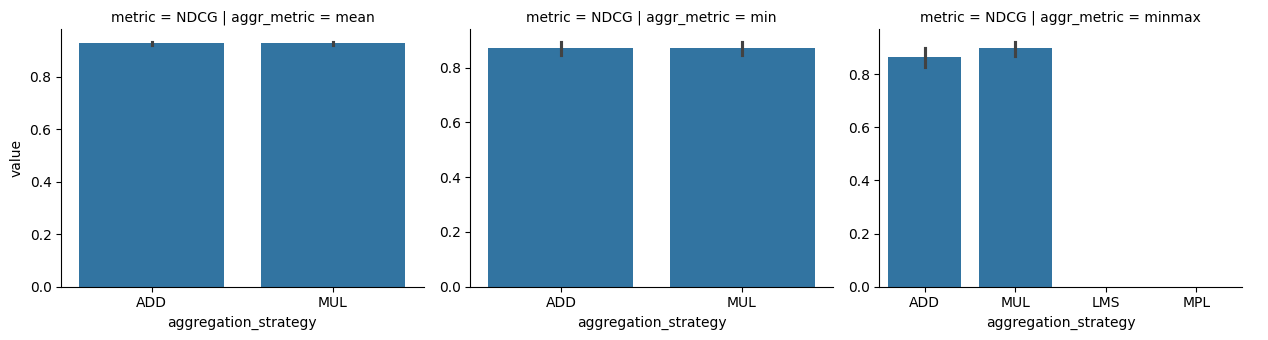

In [160]:
all_group_res = eval_df.groupby(['metric', 'aggr_metric', 'aggregation_strategy']).mean().reset_index()

g = sns.catplot(data=eval_df, row="metric", col="aggr_metric", 
                   x="aggregation_strategy", y="value", sharex=False, sharey=False,
                   kind="bar",  height=3.5, aspect=1.2)

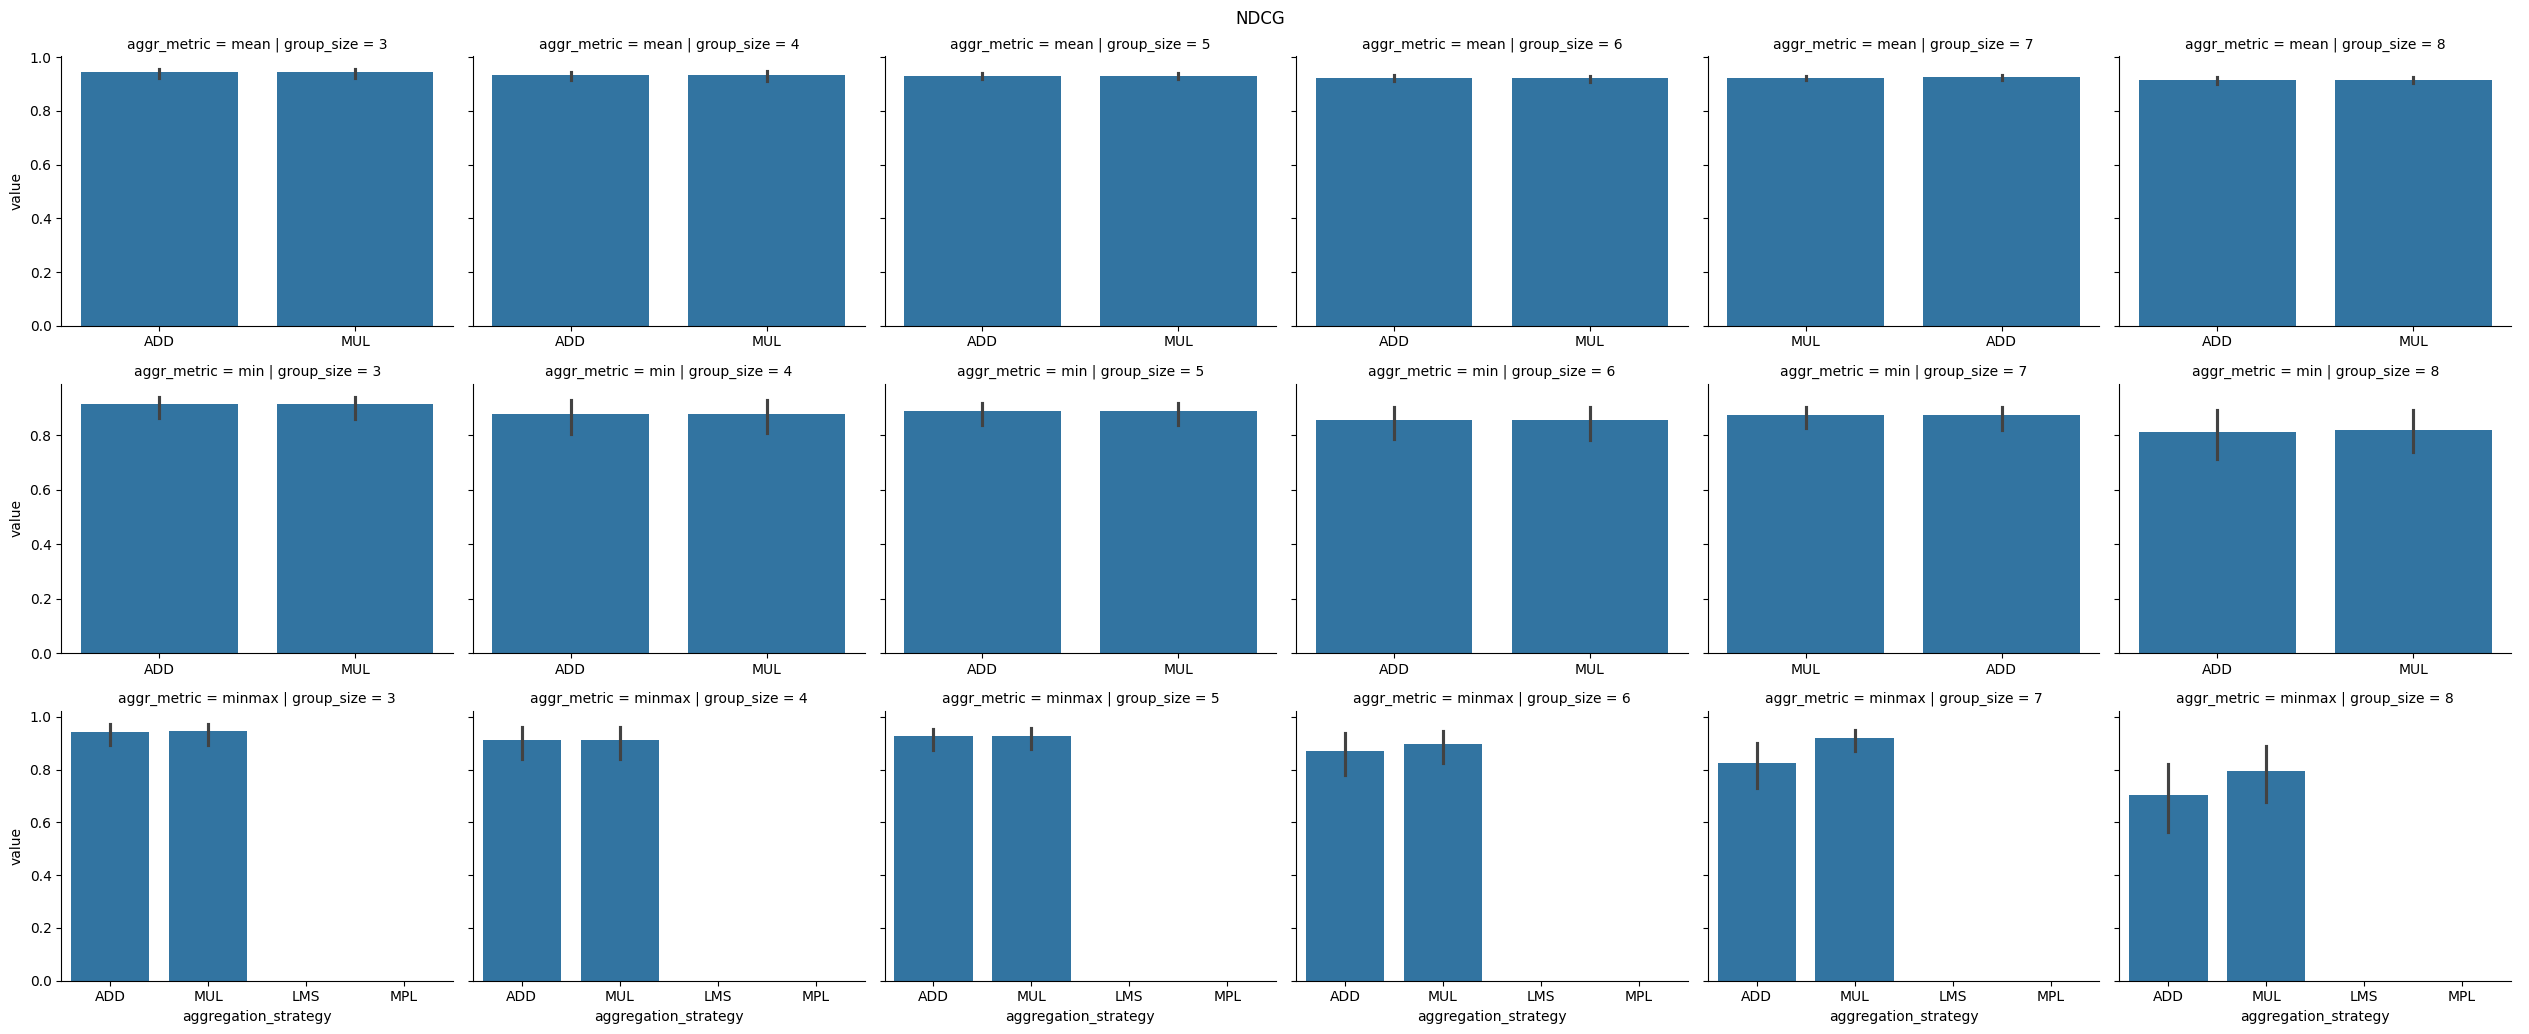

In [161]:
g = sns.catplot(data=eval_df_with_group_info, col="group_size", row="aggr_metric", 
                   x="aggregation_strategy", y="value", sharex=False, sharey="row",
                   kind="bar",  height=3.5, aspect=1.2)
plt.suptitle("NDCG")
plt.tight_layout()

In [162]:
eval_df = pd.DataFrame.from_records(coupled_results)

group_composition_DF = pd.DataFrame(group_dict).T
eval_df_with_group_info = group_composition_DF.join(eval_df.set_index("group_id")).reset_index()
eval_df_with_group_info.head()

index group_size group_similarity                group_members  \
0      0          3           random  [1055520, 1112901, 1407289]   
1      0          3           random  [1055520, 1112901, 1407289]   
2      0          3           random  [1055520, 1112901, 1407289]   
3      0          3           random  [1055520, 1112901, 1407289]   
4      0          3           random  [1055520, 1112901, 1407289]   

  avg_similarity metric aggr_metric     value aggregation_strategy  
0      -0.018266   NDCG        mean  0.952799                  ADD  
1      -0.018266   NDCG         min  0.949438                  ADD  
2      -0.018266   NDCG      minmax  0.994181                  ADD  
3      -0.018266   NDCG        mean  0.952802                  MUL  
4      -0.018266   NDCG         min  0.949327                  MUL

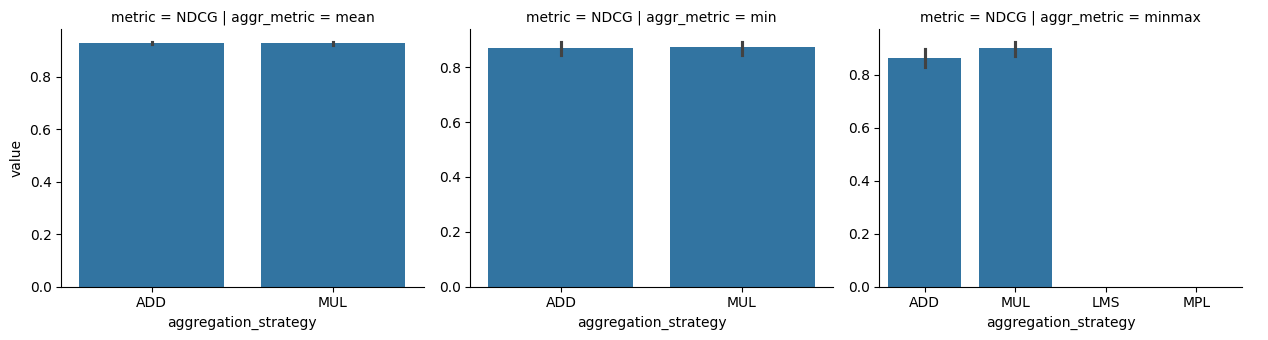

In [163]:
all_group_res = eval_df.groupby(['metric', 'aggr_metric', 'aggregation_strategy']).mean().reset_index()

g = sns.catplot(data=eval_df, row="metric", col="aggr_metric", 
                   x="aggregation_strategy", y="value", sharex=False, sharey=False,
                   kind="bar",  height=3.5, aspect=1.2)

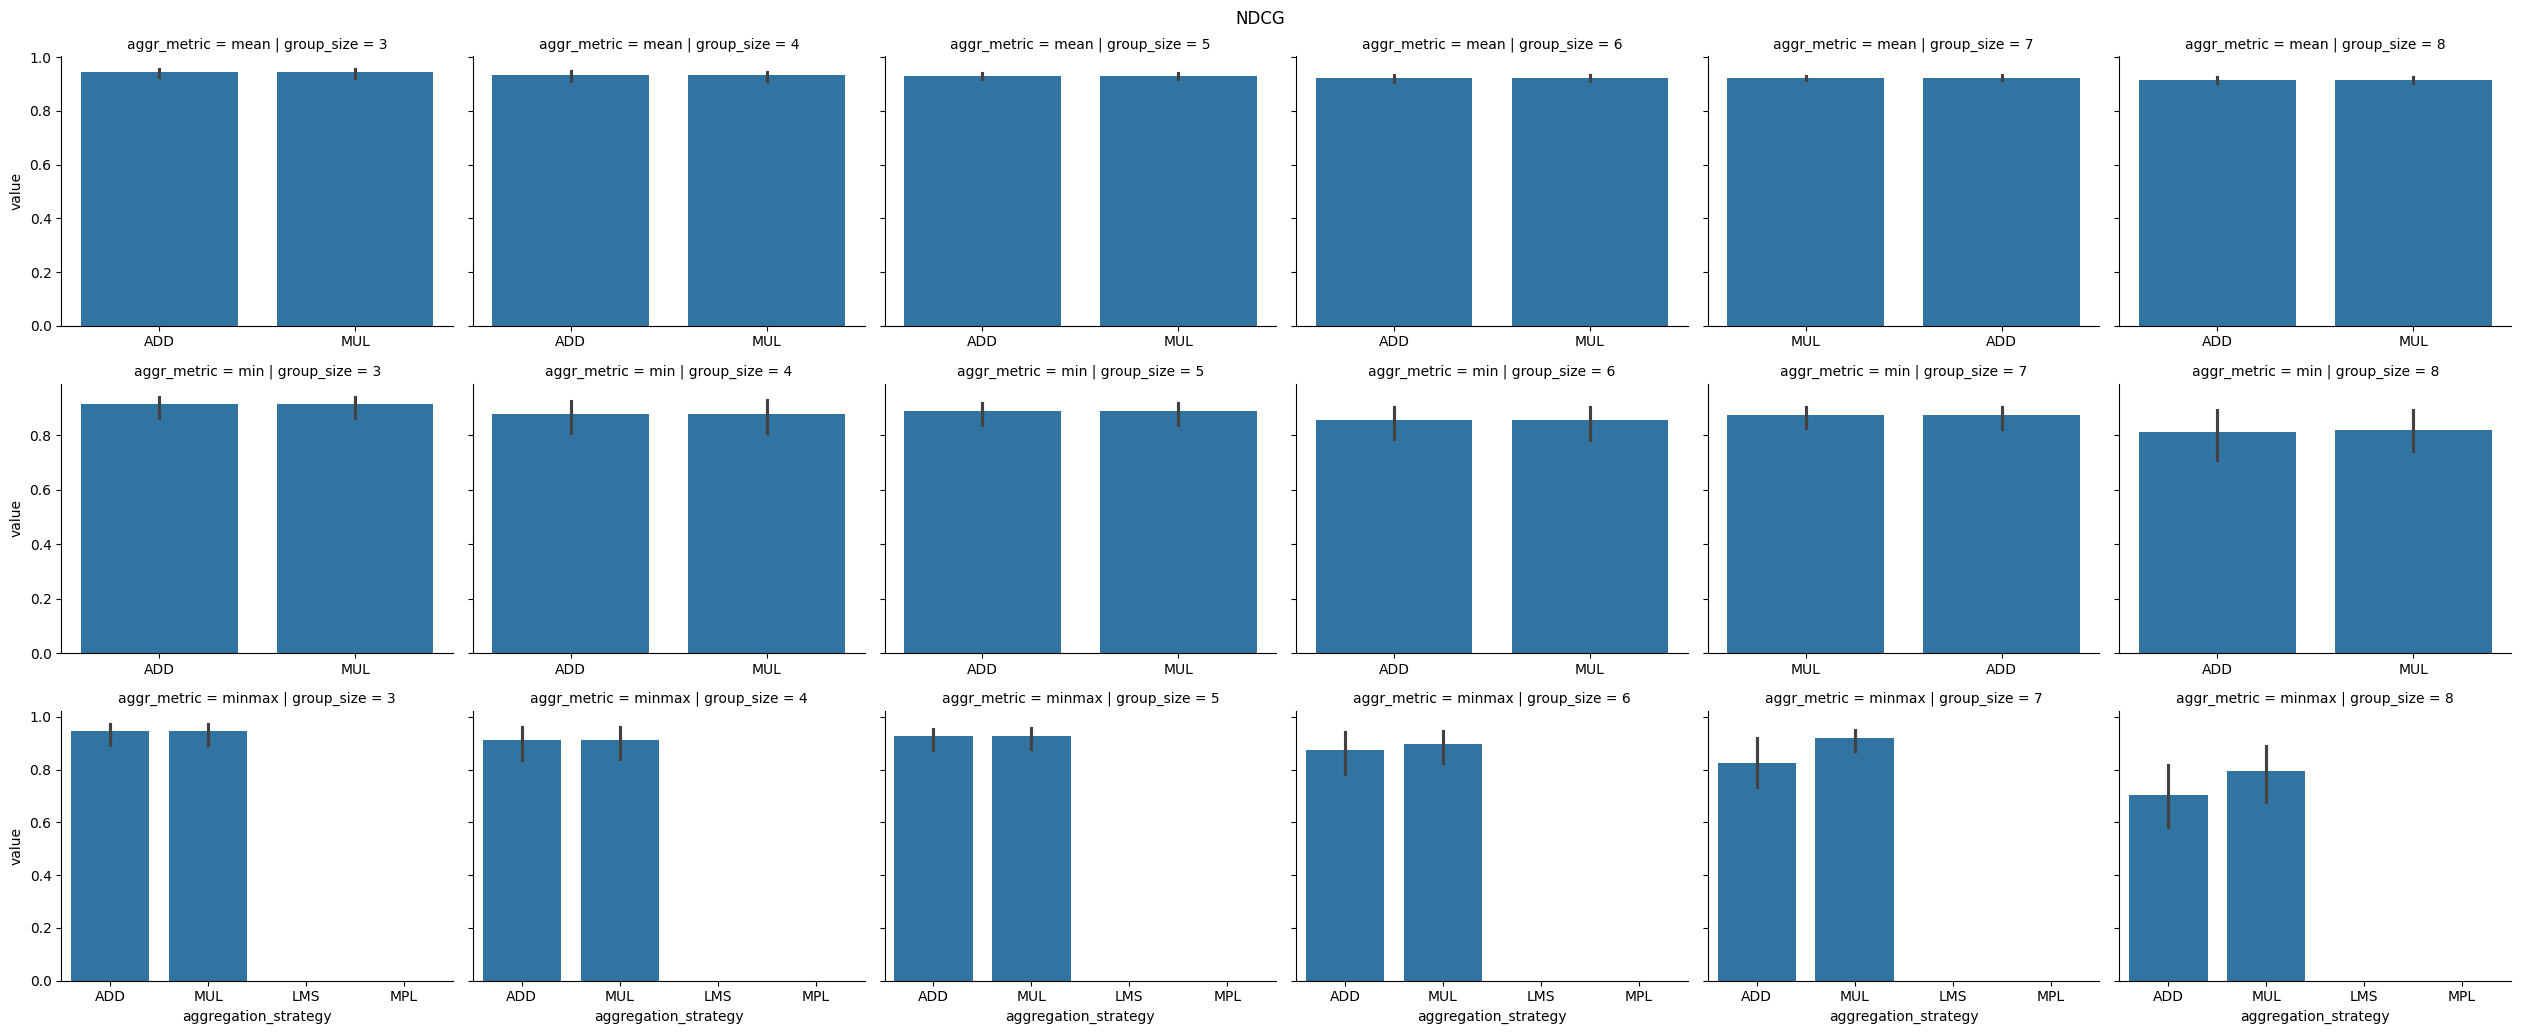

In [164]:
g = sns.catplot(data=eval_df_with_group_info, col="group_size", row="aggr_metric", 
                   x="aggregation_strategy", y="value", sharex=False, sharey="row",
                   kind="bar",  height=3.5, aspect=1.2)
plt.suptitle("NDCG")
plt.tight_layout()